# RNA-ATAC: scButterfly-B

The following tutorial demonstrate how to use scButterfly model making translation 
between scRNA-seq and scATAC-seq.

There are three part of this tutorial:

* **Read in data and load it to scButterfly**. This part will tell you how to load and pre-process scRNA-seq and scATAC-seq data for scButterfly model. 

* **Construct a scButterfly model**. This part will tell you how to generate and train a scButterfly model.

* **Get prediction and evaluate the performance**. This part will tell you how to get prediction from scButterfly model and evaluate the performance of prediction.

## Read in data and load it to scButterfly

scButterfly has integrated the process of pre-processing, constructing model, training model and evaluating in  ``scButterfly.butterfly`` for paired scRNA-seq and scATAC-seq. You could easily use it as follow:

In [1]:
from scButterfly.butterfly import Butterfly
import scanpy as sc

In [2]:
butterfly = Butterfly()

Here we use data of K562 human chronic myelogenous leukemia cell line as an example. ([Longqi Liu, et al., 2019](https://www.nature.com/articles/s41467-018-08205-7#data-availability))

In [3]:
RNA_data = sc.read_h5ad('CL_RNA.h5ad')
ATAC_data = sc.read_h5ad('CL_ATAC.h5ad')

In [4]:
RNA_data

AnnData object with n_obs × n_vars = 549 × 49059
    obs: 'batch', 'cell_type'

In [5]:
ATAC_data

AnnData object with n_obs × n_vars = 549 × 157358
    obs: 'batch', 'cell_type'
    var: 'chrom'

We provide data split settings in ``scButterfly.split_dataset`` for reproducibility. You could use parameters ``train_id``, ``validation_id`` and ``test_id`` customize your own datasets splitting settings.

In [6]:
from Butterfly.split_datasets import *
id_list = five_fold_split_dataset(RNA_data, ATAC_data)
train_id, validation_id, test_id = id_list[4]

Then we load data into scButterfly.

In [7]:
butterfly.load_data(RNA_data, ATAC_data, train_id, test_id, validation_id)

[INFO] Butterfly: successfully load in data with

RNA data:
AnnData object with n_obs × n_vars = 549 × 49059
    obs: 'batch', 'cell_type'

ATAC data:
AnnData object with n_obs × n_vars = 549 × 157358
    obs: 'batch', 'cell_type'
    var: 'chrom'


scButterfly could pre-process data Automatically, custom settings is also provided, for more information see in [API](../../API/index.html).

In [8]:
butterfly.data_preprocessing()

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.
[INFO] ATAC preprocessing: binarizing data.
[INFO] ATAC preprocessing: filter out peaks appear lower than 0.5% cells.
[INFO] ATAC preprocessing: TF-IDF transformation.
[INFO] ATAC preprocessing: normalizing data.


## Construct a scButterfly model

scButterfly model needs the information of peaks chromosomes, we should sort the ATAC data with chromosomes and tell scButterfly the count of peaks in each chromosome. 

<div class="alert note">
<p>

**Note**

To be specificly: assume that there are 3 chromosomes in ATAC profile with 6 peaks

| peak       | p1  | p2  | p3  | p4  | p5  | p6  |
| ---------- | --- | --- | --- | --- | --- | --- |
| chromosome | c2  | c1  | c3  | c1  | c1  | c2  |

We should first sort ATAC data into 

| peak       | p2  | p4  | p5  | p1  | p6  | p3  |
| ---------- | --- | --- | --- | --- | --- | --- |
| chromosome | c1  | c1  | c1  | c2  | c2  | c3  |

Then set the ``chrom_list = [3, 2, 1]``, which means 3 peaks in c1, 2 in c2 and 1 in c3.

</p>
</div>

In [9]:
butterfly.ATAC_data_p.var.chrom

chr1_10292_10791            chr1
chr1_713838_714337          chr1
chr1_762665_763164          chr1
chr1_778116_778615          chr1
chr1_805064_805563          chr1
                            ... 
chr9_140916730_140917229    chr9
chr9_140947829_140948328    chr9
chr9_140948839_140949338    chr9
chr9_140960343_140960842    chr9
chr9_140995395_140995894    chr9
Name: chrom, Length: 157358, dtype: category
Categories (22, object): ['chr1', 'chr2', 'chr3', 'chr4', ..., 'chr19', 'chr20', 'chr21', 'chr22']

<div class="alert warning">
<p>

**Warning**

Here we choose a data with chromosomes sorted, you should ensure that data is sorted by chromosomes before construct model.

</p>
</div>

In [10]:
chrom_list = []
last_one = ''
for i in range(len(butterfly.ATAC_data_p.var.chrom)):
    temp = butterfly.ATAC_data_p.var.chrom[i]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1
        
print(chrom_list, end="")

[16272, 7430, 8797, 7922, 2823, 4194, 4451, 7697, 8746, 2602, 6184, 11059, 4589, 1869, 5247, 9248, 6085, 9806, 8592, 8434, 8448, 6863]

In [11]:
sum(chrom_list)

157358

We use no data augmentation strategy here, for more information, see in [scButterfly-T](RNA_ATAC_paired_scButterfly-T.ipynb) and [scButterfly-C](RNA_ATAC_paired_scButterfly-C.ipynb).

In [12]:
butterfly.augmentation(aug_type=None)

We construct and train scButterfly model with default settings.

In [13]:
butterfly.construct_model(chrom_list=chrom_list)

[INFO] Butterfly: successfully construct butterfly model.


In [14]:
butterfly.train_model()

[INFO] Butterfly: training butterfly model ...
[INFO] Trainer: RNA pretraining ...
RNA pretrain: 100%|█████████████████████| 100/100 [02:27<00:00,  1.47s/it, train=0.5873, val=0.6376]
[INFO] Trainer: ATAC pretraining ...
ATAC pretrain: 100%|████████████████████| 100/100 [02:46<00:00,  1.66s/it, train=0.4602, val=0.4812]
[INFO] Trainer: Combine training ...
Combine training: 100%|█████████████████| 200/200 [06:22<00:00,  1.91s/it, train=1.5682, val=1.4238]


## Get prediction and evaluate the performance

You could get cross-modal predictions using ``butterfly.test_model`` with default settings. We also provided more information metrics in this function, see in [API](../../API/index.html).

In [15]:
A2R_predict, R2A_predict = butterfly.test_model()

[INFO] Butterfly: testing butterfly model ...
[INFO] Tester: get predicting ...
ATAC to RNA predicting...: 100%|██████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]
[INFO] Tester: calculate neighbors graph for following test ...


In [16]:
from scButterfly.calculate_cluster import calculate_cluster_index

Here we draw the [t-SNE](https://jmlr.org/papers/v9/vandermaaten08a.html) embeddings and measure the ARI, AMI, NMI, and HOM.

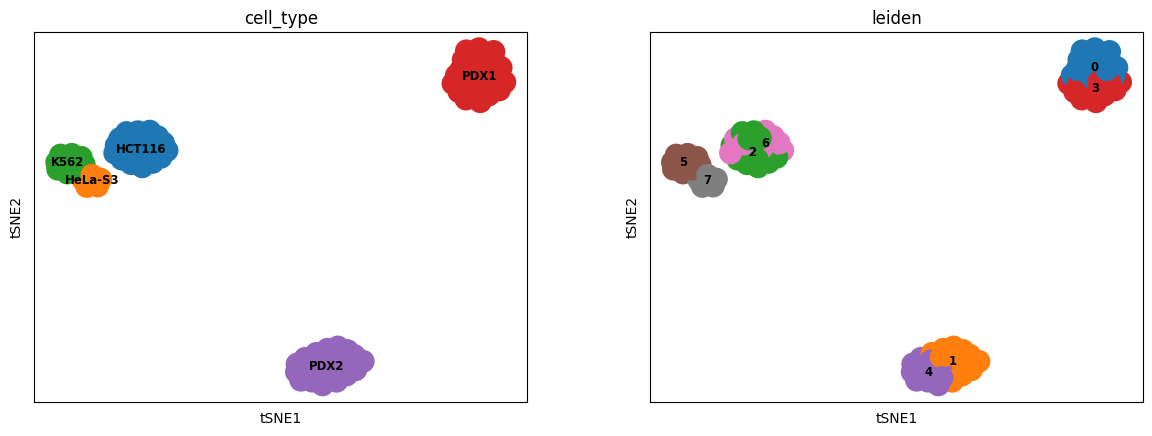

In [17]:
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)
sc.pl.tsne(A2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [18]:
ARI, AMI, NMI, HOM = calculate_cluster_index(A2R_predict)
print('ATAC to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

ATAC to RNA:
ARI: 0.620, 	AMI: 0.820, 	NMI: 0.835, 	HOM: 1.000, 	COM: 0.717


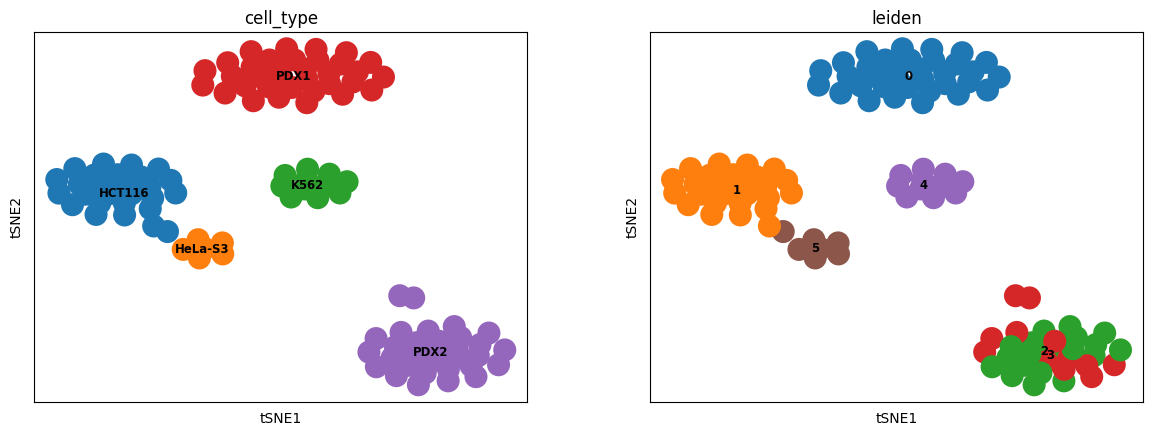

In [19]:
sc.tl.tsne(R2A_predict)
sc.tl.leiden(R2A_predict)
sc.pl.tsne(R2A_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [20]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2A_predict)
print('RNA to ATAC:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to ATAC:
ARI: 0.874, 	AMI: 0.912, 	NMI: 0.918, 	HOM: 0.982, 	COM: 0.862
